# PedSilicoICH: Part 2. Scanners

This notebook also introduces concepts of the `Scanners` Class, and assumes familiarity with the [01_phantoms.ipynb](01_phantoms.ipynb) notebook and continues from it.

In [1]:
%pip install --upgrade pip -q
%pip install matplotlib -q ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


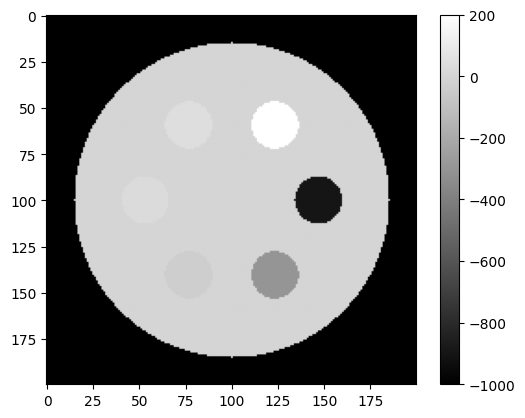

In [2]:
import matplotlib.pyplot as plt

from utils import create_circle_phantom

circles = [-900, -300, -30, 30, 45, 200]
img = create_circle_phantom(image_size=200,
                            large_circle_value=0,
                            bg_value=-1000,
                            small_circle_values=circles,
                            num_small_circles=len(circles))
plt.imshow(img, cmap='gray')
plt.colorbar()

In [3]:
from VITools import Phantom, Scanner
phantom = Phantom(img[None], spacings=(200, 1, 1))
scanner = Scanner(phantom)
scanner

Initializing Scanner object...
----------
*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 1.0-mm pixels (XY), 200.0-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ncat_adipose', 'ncat_water', 'ncat_brain', 'ncat_skull']
* mu values (/cm): [0.18, 0.21, 0.21, 0.46]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.16, 0.2, 0.21, 0.27]
* Thresholds (HU): [-200.0, -10.0, 10.0, 300.0]
*********************************************
* Calculating volume fraction maps for 4 materials and 1 slices...
* Writing volume fraction files for 4 materials and 1 slices, plus the HU data...
* Writing /tmp/tmpme26n1z2/default/phantoms/0


        <class 'VITools.scanner.Scanner'> default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        

## Use `scanner.scout_view()` to determine scan range

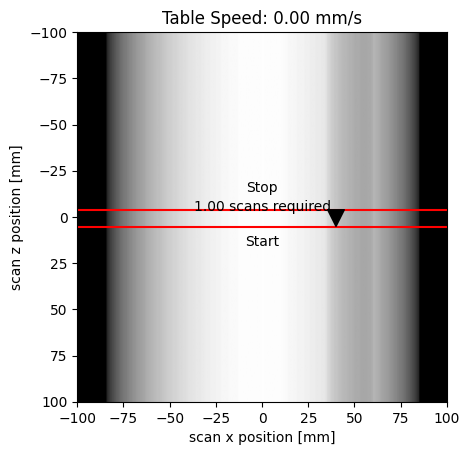

In [4]:
scans = 1  # edit me

center = 0
scan_width = 7
width = scan_width*scans
startZ = center - width / 2
endZ = center + width / 2

scanner.scout_view(startZ, endZ)

In [5]:
acquisition_technique = dict(
    mA=200,
    kVp=120,
    views=500,
    startZ=startZ,
    endZ=endZ
)
scanner.run_scan(**acquisition_technique)

scan: 1/1
Airscan


Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:52<00:00,  2.15it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.



        <class 'VITools.scanner.Scanner'> default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        

In [6]:
recon_technique = dict(
    kernel='standard',
    fov=250,
    slice_thickness=1,
    slice_increment=1
)
scanner.run_recon(**recon_technique)

fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...



        <class 'VITools.scanner.Scanner'> default_series
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        
Recon: (7, 512, 512) 25.0 cm fov
Projections: (500, 16, 900)

## View the result

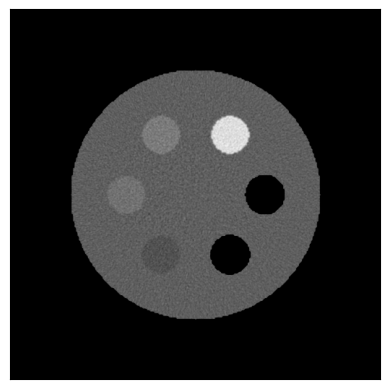

In [7]:
from utils import ctshow
ctshow(scanner.recon)

In [8]:
scanner.write_to_dicom('CTP404/CTP404.dcm')

[PosixPath('CTP404/CTP404_000.dcm'),
 PosixPath('CTP404/CTP404_001.dcm'),
 PosixPath('CTP404/CTP404_002.dcm'),
 PosixPath('CTP404/CTP404_003.dcm'),
 PosixPath('CTP404/CTP404_004.dcm'),
 PosixPath('CTP404/CTP404_005.dcm'),
 PosixPath('CTP404/CTP404_006.dcm')]

In [9]:
mAs = [20, 80, 320]
mA_recons = []
for mA in mAs:
    scanner.run_scan(mA=mA, startZ=startZ, endZ=endZ, views=500)
    scanner.run_recon(slice_thickness=1, kernel='soft')
    mA_recons.append(scanner.recon)

scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:49<00:00,  2.18it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:05<00:00,  2.69it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:13<00:00,  2.58it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...


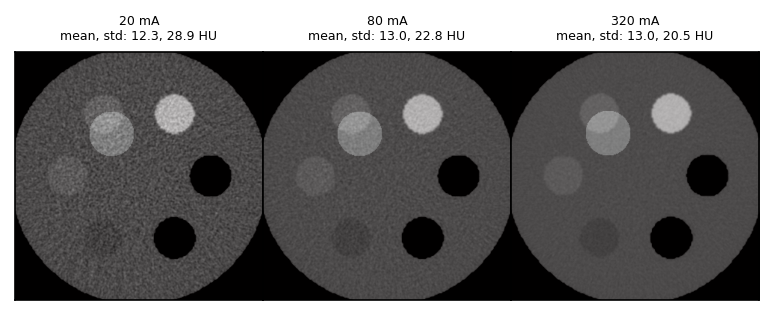

In [10]:
from utils import ctshow, center_crop, center_crop_like, circle_select
import matplotlib.pyplot as plt

roi_params = dict(
    xy = (200, 220),
    r=30
)

show_roi = True

f, axs = plt.subplots(1, len(mA_recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, mA in zip(axs.flatten(), mA_recons, mAs):
    ctshow(center_crop(recon[0]), fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{mA} mA\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [ ]:
kVps = [80, 100, 120, 140]
kVp_recons = []
for kVp in kVps:
    mA = 200 * (120 / kVp)**2 # accounts for the fact that tube output scales by kVp^2
    print(f'{kVp} kVp, {mA} mA')
    scanner.run_scan(kVp=kVp, mA=mA, startZ=startZ, endZ=endZ, views=500)
    scanner.run_recon(slice_thickness=1, kernel='soft')
    kVp_recons.append(scanner.recon)

80 kVp, 450.0 mA
scan: 1/1
Airscan


Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
100 kVp, 288.0 mA
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [02:47<00:00,  2.98it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
120 kVp, 200.0 mA
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [02:16<00:00,  3.67it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
140 kVp, 146.93877551020407 mA
scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...


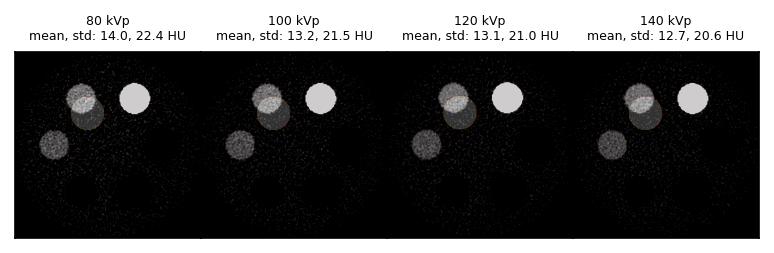

In [ ]:
show_roi = True

f, axs = plt.subplots(1, len(kVp_recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, kVp in zip(axs.flatten(), kVp_recons, kVps):
    ctshow(center_crop(recon[0]), 'brain', fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{kVp} kVp\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [ ]:
scanner.run_scan(kVp=120, mA=200, startZ=startZ, endZ=endZ, views=500)

scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<02:20,  3.55it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 500/500 [01:30<00:00,  5.51it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.



        <class 'VITools.image_acquisition.Scanner'> default
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        
Recon: (7, 512, 512) 25.0 cm fov
Projections: (500, 16, 900)

In [ ]:
kernels = ['bone', 'standard', 'soft']

recons = []
for kernel in kernels:
    scanner.run_recon(slice_thickness=1, kernel=kernel)
    recons.append(scanner.recon)

fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a n

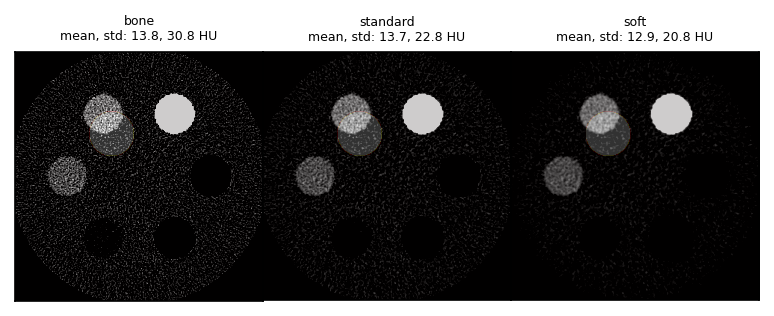

In [ ]:
show_roi = True

f, axs = plt.subplots(1, len(recons), gridspec_kw=dict(wspace=0, hspace=0), dpi=150)
for ax, recon, kernel in zip(axs.flatten(), recons, kernels):
    ctshow(center_crop(recon[0]), 'brain', fig=f, ax=ax)
    roi = circle_select(recon[0], **roi_params)
    if show_roi:
        ax.imshow(center_crop_like(roi, recon[0]), cmap='hot', alpha=0.2)
    mean = recon[0][roi].mean()
    std = recon[0][roi].std()
    ax.set_title(f'{kernel}\nmean, std: {mean:2.1f}, {std:2.1f} HU', fontsize=6)

In [ ]:
from VITools import Study

In [ ]:
study = Study(scanner)
study


        study name: default
        Phantom details:
        ----------------
        
        Phantom Class: Phantom
        Age (years): 0
        Shape (voxels): [1, 200, 200]
        Size (mm): [200 200 200]
        

        Scanner details:
        ----------------
        Scanner: 
        <class 'VITools.image_acquisition.Scanner'> default
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        
Recon: (7, 512, 512) 25.0 cm fov
Projections: (500, 16, 900)

        Study details:
        --------------
        None
        

In [ ]:
study.run_study?

Signature:
study.run_study(
    output_directory=None,
    kVp=120,
    mA=200,
    pitch=0,
    views=1000,
    fov=250,
    zspan='dynamic',
    kernel='standard',
    slice_thickness=1,
    slice_increment=None,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/Dev/VITools/src/VITools/pipeline.py
Type:      method

In [ ]:
study.run_study(zspan=(startZ, endZ))

scan: 1/1
Airscan
Offset scan
Phantom scan


  0%|          | 1/1000 [00:00<04:54,  3.39it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      0 MB.


100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


Prep view
Applying LSC...done.

Applying Beam Hardening Correction (ACCURATE BHC)...Airscan
done.

Simulation is done.
fov size: 250
* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...



        study name: default
        Phantom details:
        ----------------
        
        Phantom Class: Phantom
        Age (years): 0
        Shape (voxels): [1, 200, 200]
        Size (mm): [200 200 200]
        

        Scanner details:
        ----------------
        Scanner: 
        <class 'VITools.image_acquisition.Scanner'> default
        Scanner: Scanner_Default
        Simulation Platform: CATSIM
        
Recon: (7, 512, 512) 25.0 cm fov
Projections: (1000, 16, 900)

        Study details:
        --------------
              Name  Age  kVp   mA  Views ReconKernel  SliceThickness(mm)  \
0  default    0  120  200   1000    standard                   1   
1  default    0  120  200   1000    standard                   1   
2  default    0  120  200   1000    standard                   1   
3  default    0  120  200   1000    standard                   1   
4  default    0  120  200   1000    standard                   1   
5  default    0  120  200   1000    standard  

In [ ]:
study.metadata

,Name,Age,kVp,mA,Views,ReconKernel,SliceThickness(mm),LesionAttenuation(HU),LesionVolume(mL),Subtype,MassEffect,CenterX,CenterY,CenterZ,FOV(mm),ImageFilePath,MaskFilePath
0,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_000.dcm,None
1,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_001.dcm,None
2,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_002.dcm,None
3,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_003.dcm,None
4,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_004.dcm,None
5,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_005.dcm,None
6,default,0,120,200,1000,standard,1,None,[0.0],None,None,None,None,None,250,/tmp/tmpikpnmpou/default/dicoms/default_006.dcm,None
